<a href="https://colab.research.google.com/github/ThinkingRed/SadnessDiscordBot/blob/main/sadnessAnalyzerTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

In [ ]:
!pip install transformers

In [ ]:
!pip install bert-tensorflow

In [4]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
from matplotlib import pyplot as plt

import transformers

from keras.utils import np_utils

from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AutoModelForSequenceClassification

from torch.utils.data import RandomSampler,SequentialSampler,DataLoader

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

##Dataset Sourcing##

The following datasets were taken from https://www.kaggle.com/datasets/hyunkic/twitter-depression-dataset?select=clean_non_d_tweets.csv. I had downloaded the depressing and non depressing (both clean) datasets. 

In [5]:
disorderdf = pd.read_csv('/content/drive/MyDrive/MentalHealthDataSet/clean_d_tweets.csv')
setLength = len(disorderdf)
normaldf = pd.read_csv('/content/drive/MyDrive/MentalHealthDataSet/clean_non_d_tweets.csv',
                       nrows = setLength)

In [6]:
dTweets = disorderdf.tweet.values
nTweets = normaldf.tweet.values

## Label all the data

This makes a labeled data csv which will be used for the training and testing. Altogether, there are 6162 tweets with an equal split between those labeled "disordered" and "normal" where disordered means they show some sort of mental health issue.



In [7]:
from array import array 

DisorderArray = dTweets.reshape(setLength, 1)
NormalArray = nTweets.reshape(setLength, 1)

labeledArray = []
i = 1
while i < setLength:
  j = int(i-1)
  labeledArray.append(DisorderArray[j])
  labeledArray.append(int(1)) #if it's disordered, it'll be 1
  i = i+1

m = 1
while m < setLength:
  labeledArray.append(NormalArray[m-1])
  labeledArray.append(int(0)) #if it's normal, it'll be 0
  m = m+1

newLDA = np.array(labeledArray)
LA = newLDA.reshape(int(2*setLength)-2, 2)

LAdf = pd.DataFrame(LA)
LAdf.to_csv("/content/labeledData.csv", header  = ['tweet','label'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [8]:
df = pd.read_csv('/content/labeledData.csv')
x = df.tweet.values 
y = df.label.values 

In [52]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=9)

In [53]:
x_testA = pd.DataFrame(x_test)
x_testA.to_csv("/content/x_test.csv", header = ["tweet"])

x_trainA = pd.DataFrame(x_train)
x_trainA.to_csv("/content/x_train.csv", header = ["tweet"])

In [54]:
y_testA = pd.DataFrame(y_test)
y_testA.to_csv("/content/y_test.csv", header = ["label"])

y_trainA = pd.DataFrame(y_train)
y_trainA.to_csv("/content/y_train.csv", header = ["label"])

## Tokenization


In [55]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [56]:
sampleText = 'I was just playing in the yard earlier.'

In [57]:
tokens = tokenizer.tokenize(sampleText)
tokenId = tokenizer.convert_tokens_to_ids(tokens)
print(tokens)
print(tokenId)

['I', 'was', 'just', 'playing', 'in', 'the', 'yard', 'earlier', '.']
[146, 1108, 1198, 1773, 1107, 1103, 3723, 2206, 119]


In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]', '[PAD]', '[UNK]'])

In [ ]:
encoding = tokenizer.encode_plus(
    sampleText,
    max_length=70,
    add_special_tokens=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
) # this is only to test out the tokenizer
encoding.keys()

In [ ]:
print(encoding)

In [ ]:
tokenLens = []
for tweet in x:
  tokens = tokenizer.encode(tweet)
  tokenLens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


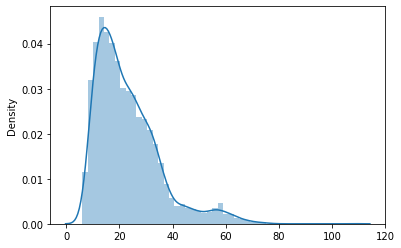

In [ ]:
import seaborn as sns
sns.distplot(tokenLens);

From that, it seems that using a max of about 70 would be good for this project. 

In [58]:
MaxLens = 70
BatchSize = 8
Epochs = 20

In [59]:
xTraindf = pd.read_csv('/content/x_train.csv')
xTestdf = pd.read_csv('/content/x_test.csv')

encoderTrain = tokenizer.batch_encode_plus(
                xTraindf.tweet.values,
                max_length=70,
                add_special_tokens=True,
                pad_to_max_length=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                return_tensors='pt')

encoderTest = tokenizer.batch_encode_plus(
                xTestdf.tweet.values,
                max_length=70,
                add_special_tokens=True,
                pad_to_max_length=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                return_tensors='pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [60]:
import torch

yTraindf = pd.read_csv('/content/y_train.csv')
yTestdf = pd.read_csv('/content/y_test.csv')

inputIdsTrain = encoderTrain['input_ids']
attentionMarksTrain = encoderTrain['attention_mask']
labelsTrain = torch.tensor(yTraindf.label.values)

inputIdsTest = encoderTest['input_ids']
attentionMarksTest = encoderTest['attention_mask']
labelsTest = torch.tensor(yTestdf.label.values)

In [61]:
from torch.utils.data import TensorDataset

dataTrain = TensorDataset(inputIdsTrain,attentionMarksTrain,labelsTrain)
dataTest = TensorDataset(inputIdsTest,attentionMarksTest,labelsTest)

## Model

In [76]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                     num_labels = 2,
                                     output_attentions = False,
                                     output_hidden_states =  False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [77]:
dataloaderTrain = DataLoader(
    dataTrain,
    sampler= RandomSampler(dataTrain),
    batch_size = 16
    
)


dataloaderTest = DataLoader(
    dataTest,
    sampler= RandomSampler(dataTest),
    batch_size = 32
    
)

from transformers import AdamW,get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),lr = 1e-5,eps = 1e-8)

epochs  = 10
scheduler = get_linear_schedule_with_warmup(
            optimizer,
    num_warmup_steps = 0,
   num_training_steps = len(dataloaderTrain)*epochs 
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [78]:
from sklearn.metrics import f1_score 

def f1_score_func(preds,labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat,preds_flat,average = 'weighted')

def accuracy_per_class(preds,labels):
    label_dict_reverse = {v:k for k,v in dict_label.items()}
    
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f"Class:{label_dict_reverse}")
        print(f"Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n")

import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [79]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

def evaluate(dataloader_val):
    model.eval()
    
    loss_val_total = 0
    predictions,true_vals = [],[]
    
    for batch in tqdm(dataloader_val):
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':  batch[0],
                  'attention_mask':batch[1],
                  'labels': batch[2]
                 }
        with torch.no_grad():
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total +=loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        
        
    loss_val_avg = loss_val_total/len(dataloader_val)  
    
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0) 
    return loss_val_avg,predictions,true_vals

In [80]:
for epoch in tqdm(range(1,epochs+1)):
    model.train()
    
    loss_train_total=0
    
    progress_bar = tqdm(dataloaderTrain,desc = "Epoch: {:1d}".format(epoch),leave = False,disable = False)
    
    
    for batch in progress_bar:
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            "input_ids":batch[0],
            "attention_mask":batch[1],
            "labels":batch[2]
            
        }
        outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_train_total +=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm(model.parameters(),1.0)
        
        optimizer.step()
        scheduler.step()
        
        
        progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})
      
    tqdm.write('\nEpoch {epoch}')
    torch.save(model.state_dict(),f'/content/drive/MyDrive/modelSaves/tester_r2_epoch{epoch}.pth')
    loss_train_avg = loss_train_total/len(dataloaderTrain)
    tqdm.write(f'Training Loss: {loss_train_avg}')
    val_loss,predictions,true_vals = evaluate(dataloaderTest)
    test_score = f1_score_func(predictions,true_vals)
    tqdm.write(f'Val Loss:{val_loss}\n Test Score:{test_score}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1:   0%|          | 0/328 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch {epoch}
Training Loss: 0.5661501435154095


  0%|          | 0/29 [00:00<?, ?it/s]

Val Loss:0.4124461304524849
 Test Score:0.8054659051881976


Epoch: 2:   0%|          | 0/328 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch {epoch}
Training Loss: 0.41424130478010673


  0%|          | 0/29 [00:00<?, ?it/s]

Val Loss:0.40174349371729223
 Test Score:0.8085709055709619


Epoch: 3:   0%|          | 0/328 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch {epoch}
Training Loss: 0.3273793561270506


  0%|          | 0/29 [00:00<?, ?it/s]

Val Loss:0.41616538166999817
 Test Score:0.8233940917661847


Epoch: 4:   0%|          | 0/328 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch {epoch}
Training Loss: 0.2632447210503969


  0%|          | 0/29 [00:00<?, ?it/s]

Val Loss:0.34922826649813815
 Test Score:0.8648848060813241


Epoch: 5:   0%|          | 0/328 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch {epoch}
Training Loss: 0.21579609048643672


  0%|          | 0/29 [00:00<?, ?it/s]

Val Loss:0.3772505696477561
 Test Score:0.8632378913567033


Epoch: 6:   0%|          | 0/328 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch {epoch}
Training Loss: 0.19026676668336887


  0%|          | 0/29 [00:00<?, ?it/s]

Val Loss:0.4410764527475012
 Test Score:0.8539602283093122


Epoch: 7:   0%|          | 0/328 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch {epoch}
Training Loss: 0.1582018044030453


  0%|          | 0/29 [00:00<?, ?it/s]

Val Loss:0.48171248775104
 Test Score:0.8649240133425048


Epoch: 8:   0%|          | 0/328 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch {epoch}
Training Loss: 0.12556499536021432


  0%|          | 0/29 [00:00<?, ?it/s]

Val Loss:0.566733938352815
 Test Score:0.8702559811139916


Epoch: 9:   0%|          | 0/328 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch {epoch}
Training Loss: 0.11371339461091827


  0%|          | 0/29 [00:00<?, ?it/s]

Val Loss:0.5745004605630348
 Test Score:0.8703234133009413


Epoch: 10:   0%|          | 0/328 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch {epoch}
Training Loss: 0.09541438650992903


  0%|          | 0/29 [00:00<?, ?it/s]

Val Loss:0.6067228917482084
 Test Score:0.8638643892425925
